# Use flexible boundary integral formulations

The OptimUS library provides acoustic wave simulations for scattering at multiple objects. The boundary element method (BEM) solves a boundary integral formulation of the Helmholtz equation to calculate the pressure field. Normally, a specific boundary integral formulation is used for the entire domain. However, the OptimUS library allows to use different boundary integral formulations for different interfaces. This can be useful to improve the convergence of the iterative solver, especially for large contrasts in material parameters. This notebook demonstrates the use of different boundary integral formulations for a model with multiple scatterers.

In [1]:
# Import development version of OptimUS
%matplotlib inline
import sys
sys.path.append('..')
import optimus

In [2]:
print(optimus.__version__)

0.2.0


## Specify the geometry, material and wave parameters

Let us use a benchmark for multiple scattering at two separate spheres. The incident wave field is a plane wave
Let us use a standard incident wave field, given by a plane wave with a given direction and frequency. The exterior domain models water and the two bounded spheres model fat and bone.

In [3]:
frequency = 150e3
source = optimus.source.create_planewave(frequency, direction=(0,1,0))
material_ext = optimus.material.load_material('water')
material1, material2 = optimus.material.load_material(('fat', 'bone (cortical)'))

In [4]:
geometry1 = optimus.geometry.shapes.Sphere(radius=5e-3, origin=(-7e-3,0,0), element_size=1e-3, label="sphere1")
geometry2 = optimus.geometry.shapes.Sphere(radius=5e-3, origin=(7e-3,0,0), element_size=1e-3, label="sphere2")

In [5]:
print("The mesh on interface " + geometry1.label + " has " + str(geometry1.number_of_vertices()) + " vertices.")
print("The mesh on interface " + geometry2.label + " has " + str(geometry2.number_of_vertices()) + " vertices.")

The mesh on interface sphere1 has 426 vertices.
The mesh on interface sphere2 has 426 vertices.


In [6]:
mygraph = optimus.geometry.Graph("two_scatterers")
mygraph.create_exterior_domain(material_ext, source)
mygraph.create_interface(geometry1, 0, material1)
mygraph.create_interface(geometry2, 0, material2)

In [7]:
mygraph.print_graph_information()

Label of graph: two_scatterers
Number of subdomain nodes: 3
Number of interface nodes: 3
Number of edges: 4
Number of interface connectors: 5

Topology of subdomain nodes:
 Subdomain node 0:
  Parent interface: 0
  Child interfaces: [1, 2]
  Bounded: False
 Subdomain node 1:
  Parent interface: 1
  Child interfaces: []
  Bounded: True
 Subdomain node 2:
  Parent interface: 2
  Child interfaces: []
  Bounded: True

Topology of interface nodes:
 Interface node 0:
  Parent subdomain: None
  Child subdomain: 0
  Parent interface: None
  Sibling interfaces: []
  Child interfaces: [1, 2]
  Bounded: False
 Interface node 1:
  Parent subdomain: 0
  Child subdomain: 1
  Parent interface: 0
  Sibling interfaces: [2]
  Child interfaces: []
  Bounded: True
 Interface node 2:
  Parent subdomain: 0
  Child subdomain: 2
  Parent interface: 0
  Sibling interfaces: [1]
  Child interfaces: []
  Bounded: True

Topology of edges:
 Edge 0:
  Subdomain node: 0
  Interface node: 1
  Orientation: interface_in

Let's visualise the geometry to check if the domains are correctly defined.

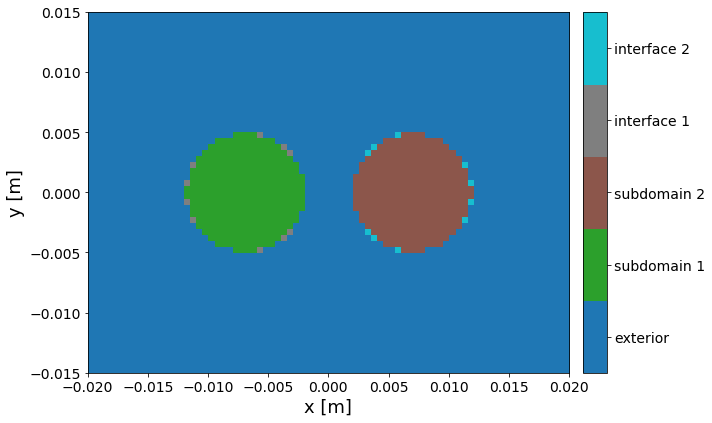

In [8]:
model_graph = optimus.model.create_default_nested_model(mygraph, frequency)
postprocess_graph = optimus.postprocess.VisualisePlane(model_graph)
postprocess_graph.create_computational_grid(resolution=(80, 60), bounding_box=(-20e-3, 20e-3, -15e-3, 15e-3))
fig = optimus.postprocess.plot_regions(postprocess_graph)

## Create the computational model

The OptimUS library solves acoustic wave propagation with the BEM. This requires specifying boundary integral formulations at the material interfaces. The library has functionality for different types of boundary integral formulations and preconditioners. Among the most common ones are the PMCHWT and Müller formulations, which are single-trace formulation of the first and second kind, respectively. Each formulation has different computation characteristics in terms of memory footprint, compressibility, accuracy, and convergence. Furthermore, the convergence of the linear solver depends on material parameters such as the contrast in sound speed and density, as well as wave parameters such as frequency. A key component of the flexible BEM implementation in OptimUS is that different formulations can be combined. Specifically, different boundary integral formulations at different material interfaces can be coupled into a consistent model.

Here, let us compare combinations of PMCHWT and Müller formulations for the two interfaces. The mass matrix preconditioner will be used for all interfaces, by default.

In [9]:
model_pp = optimus.model.create_nested_model(mygraph, frequency, ["pmchwt", "pmchwt"], "mass")
model_mp = optimus.model.create_nested_model(mygraph, frequency, ["muller", "pmchwt"], "mass")
model_pm = optimus.model.create_nested_model(mygraph, frequency, ["pmchwt", "muller"], "mass")
model_mm = optimus.model.create_nested_model(mygraph, frequency, ["muller", "muller"], "mass")

We con now solve the BEM models. Depending on the grid resolution this may take long computation times.

In [10]:
%%time
model_pp.solve(timing=True)
model_mp.solve(timing=True)
model_pm.solve(timing=True)
model_mm.solve(timing=True)

CPU times: user 5min 18s, sys: 12.9 s, total: 5min 31s
Wall time: 41.4 s


Let us visualise the pressure field on the plane to check the results.

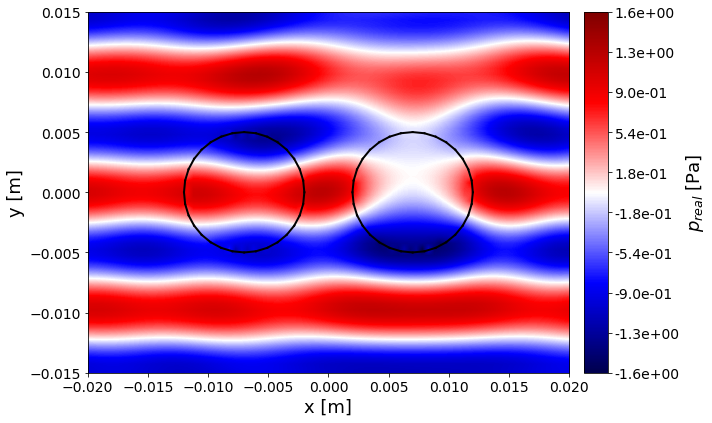

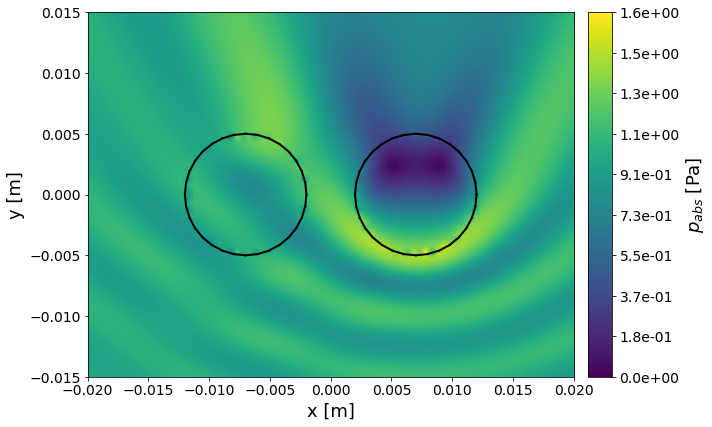

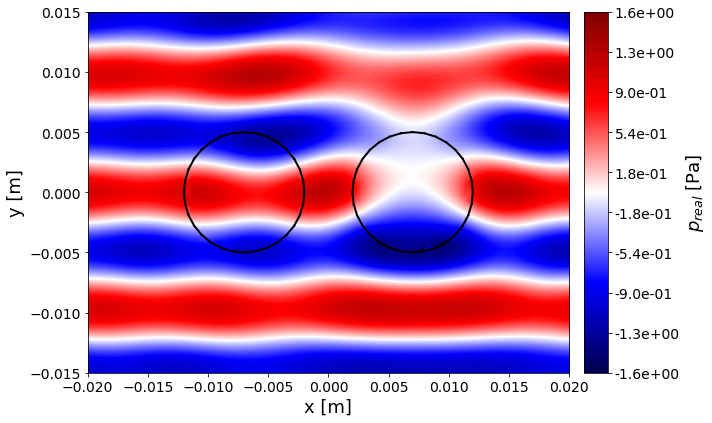

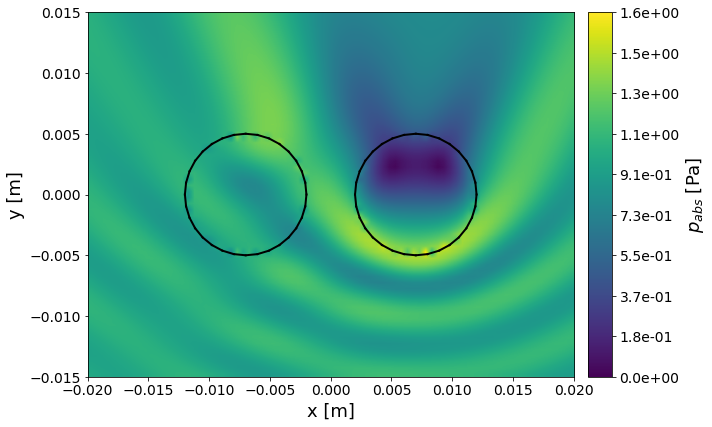

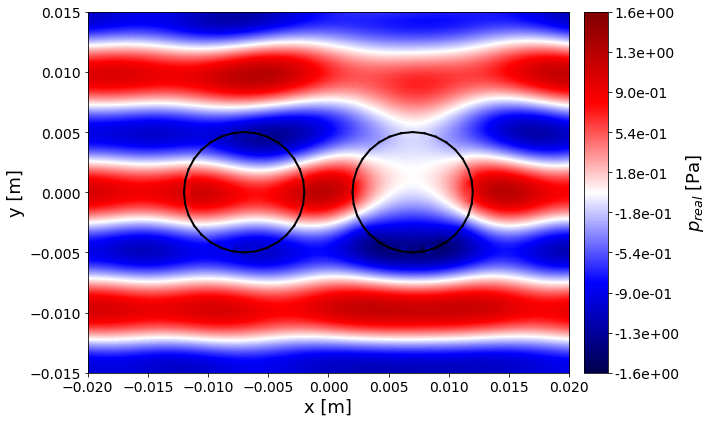

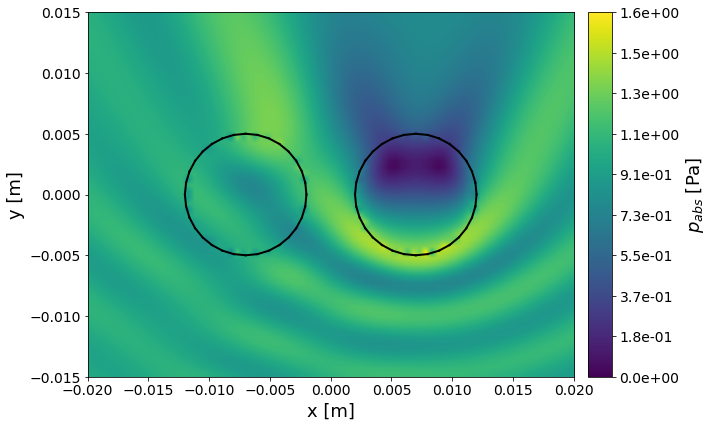

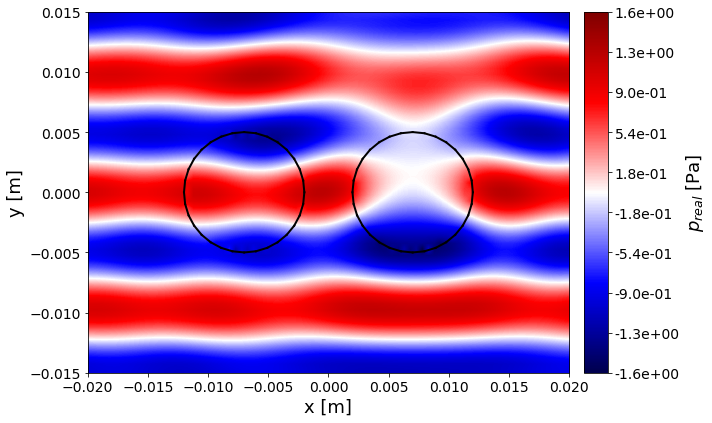

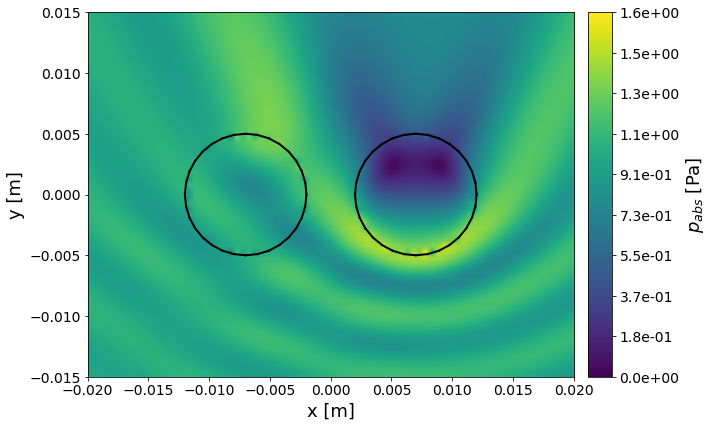

In [11]:
for model in [model_pp, model_mp, model_pm, model_mm]:
    postprocess_plane = optimus.postprocess.VisualisePlane(model)
    postprocess_plane.create_computational_grid(resolution=(80, 60), bounding_box=(-20e-3, 20e-3, -15e-3, 15e-3))
    postprocess_plane.compute_fields()
    _ = optimus.postprocess.plot_pressure_field(postprocess_plane)

Let us compare the computation times and number of iterations for the different models.

In [13]:
for model in [model_pp, model_mp, model_pm, model_mm]:
    print(
        "The model with %s and %s formulations took %.2f seconds and %i iterations to solve."
        %(model.formulation[1], model.formulation[2], model.timings["linear solve"], model.iteration_count)
    )

The model with pmchwt and pmchwt formulations took 0.39 seconds and 16 iterations to solve.
The model with muller and pmchwt formulations took 0.28 seconds and 18 iterations to solve.
The model with pmchwt and muller formulations took 0.34 seconds and 20 iterations to solve.
The model with muller and muller formulations took 0.32 seconds and 14 iterations to solve.


Indeed, the computational performance depends on the choice of boundary integral formulation.